```
!/mnt2/kireev/pipenv_envs/pytorch-lifestream-bcSZKFyz/bin/kaggle datasets download -d nphantawee/pump-sensor-data

ls -l

!unzip pump-sensor-data.zip
```

In [1]:
import sys

In [2]:
sys.path.append('../../')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [4]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [5]:
import torch
import pytorch_lightning as pl

In [6]:
import logging
logging.getLogger('pytorch_lightning').setLevel(logging.INFO)

In [7]:
import warnings

# Data

In [8]:
df_data = pd.read_csv('sensor.csv', index_col=0)

In [9]:
df_data['timestamp'] = pd.to_datetime(df_data['timestamp'])

In [10]:
df_data = df_data.set_index('timestamp').sort_index()

In [11]:
y_data = df_data['machine_status']

In [12]:
x_data = df_data.drop(columns='machine_status')

In [13]:
x_data.isna().mean().sort_values()

sensor_23    0.000073
sensor_28    0.000073
sensor_27    0.000073
sensor_34    0.000073
sensor_24    0.000073
sensor_35    0.000073
sensor_36    0.000073
sensor_21    0.000073
sensor_20    0.000073
sensor_19    0.000073
sensor_37    0.000073
sensor_33    0.000073
sensor_31    0.000073
sensor_13    0.000086
sensor_11    0.000086
sensor_02    0.000086
sensor_10    0.000086
sensor_03    0.000086
sensor_12    0.000086
sensor_04    0.000086
sensor_05    0.000086
sensor_26    0.000091
sensor_14    0.000095
sensor_45    0.000123
sensor_43    0.000123
sensor_42    0.000123
sensor_41    0.000123
sensor_38    0.000123
sensor_39    0.000123
sensor_44    0.000123
sensor_40    0.000123
sensor_47    0.000123
sensor_48    0.000123
sensor_46    0.000123
sensor_49    0.000123
sensor_16    0.000141
sensor_25    0.000163
sensor_22    0.000186
sensor_18    0.000209
sensor_17    0.000209
sensor_32    0.000309
sensor_29    0.000327
sensor_30    0.001185
sensor_01    0.001675
sensor_09    0.020856
sensor_06 

In [14]:
y_data.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

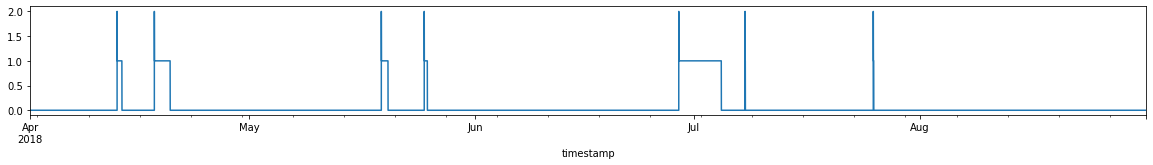

In [15]:
y_data.map({'NORMAL': 0, 'RECOVERING': 1, 'BROKEN': 2}).plot(figsize=(20, 2))
plt.show()

In [16]:
x_data = x_data.fillna(method='ffill').drop(columns='sensor_15')

In [17]:
x_data.index.max() - x_data.index.min()

Timedelta('152 days 23:59:00')

In [18]:
len(x_data), len(x_data) / 153

(220320, 1440.0)

In [19]:
print('Mean recovering time {:1f}'.format(y_data.eq('RECOVERING').sum() / y_data.eq('BROKEN').sum()))

Mean recovering time 2068.142857


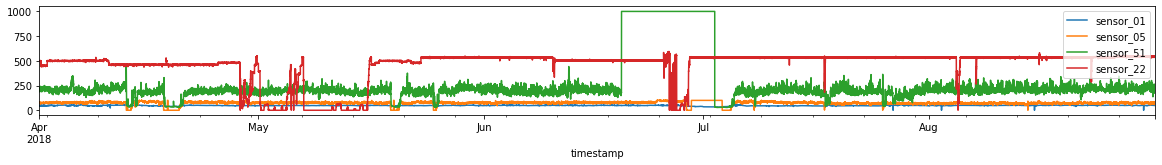

In [20]:
x_data.iloc[:, np.random.choice(x_data.shape[1], 4, replace=False)].plot(figsize=(20, 2))
plt.show()

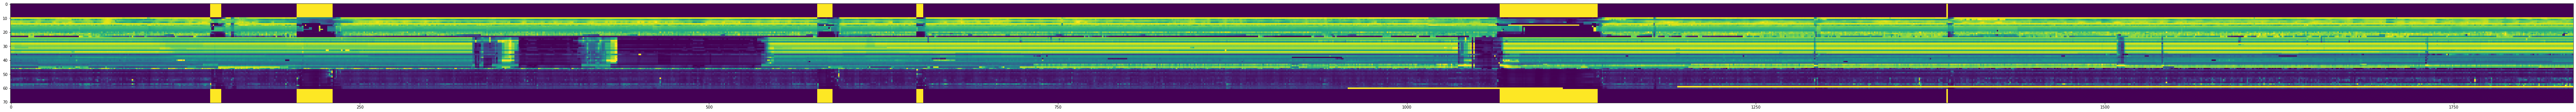

In [21]:
_, axs = plt.subplots(1, 1, figsize=(120, 3 * 5))

t = x_data.values[::120, :]
t = t - t.min(axis=0, keepdims=True)
t = t / t.max(axis=0, keepdims=True)
tx = t

axs.imshow(np.concatenate([
    (y_data != 'NORMAL').values.astype(float).reshape(1, -1).repeat(10, 0)[:, ::120],
    tx.T,
    (y_data != 'NORMAL').values.astype(float).reshape(1, -1).repeat(10, 0)[:, ::120],
], axis=0))
plt.show()

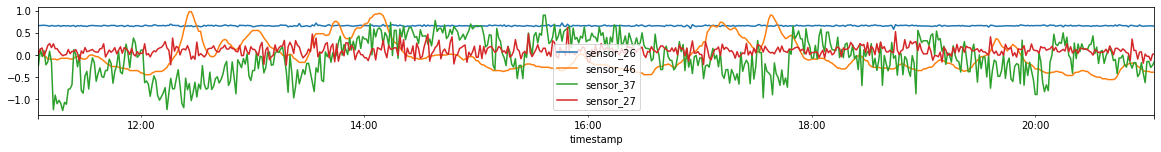

In [22]:
p = np.random.randint(0, 220320 - 120 * 5)
((x_data - x_data.mean()) / x_data.std()).clip(-5, 5) \
    .iloc[p : p + 120 * 5, np.random.choice(x_data.shape[1], 4, replace=False)].plot(figsize=(20, 2))
plt.show()

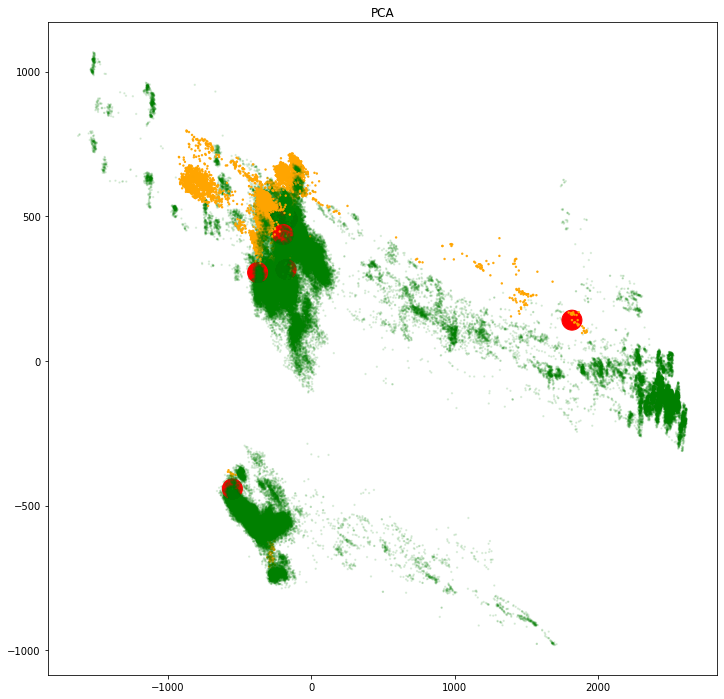

In [23]:
pca = PCA(n_components=2)
r_pca = pca.fit_transform(x_data.values)

plt.figure(figsize=(12, 12))
plt.scatter(
    r_pca[:, 0], r_pca[:, 1],
    c=y_data.map({'NORMAL': 'green', 'RECOVERING': 'orange', 'BROKEN': 'red'}).values,
    s=y_data.map({'NORMAL': 2, 'RECOVERING': 2, 'BROKEN': 400}).values,
    alpha=y_data.map({'NORMAL': 0.1, 'RECOVERING': 0.9, 'BROKEN': 1.0}).values,
)
plt.title('PCA')
plt.show()

# Feature construction approach

In [24]:
predict_size = 10

In [25]:
y_data = y_data.map({'NORMAL': 0}).fillna(1)

In [26]:
y_target = y_data.rolling(window=predict_size, min_periods=1).max().shift(-predict_size)

In [27]:
y_target.iloc[-20:]

timestamp
2018-08-31 23:40:00    0.0
2018-08-31 23:41:00    0.0
2018-08-31 23:42:00    0.0
2018-08-31 23:43:00    0.0
2018-08-31 23:44:00    0.0
2018-08-31 23:45:00    0.0
2018-08-31 23:46:00    0.0
2018-08-31 23:47:00    0.0
2018-08-31 23:48:00    0.0
2018-08-31 23:49:00    0.0
2018-08-31 23:50:00    NaN
2018-08-31 23:51:00    NaN
2018-08-31 23:52:00    NaN
2018-08-31 23:53:00    NaN
2018-08-31 23:54:00    NaN
2018-08-31 23:55:00    NaN
2018-08-31 23:56:00    NaN
2018-08-31 23:57:00    NaN
2018-08-31 23:58:00    NaN
2018-08-31 23:59:00    NaN
Name: machine_status, dtype: float64

# Supervised NN

In [28]:
x_data.shape, y_target.shape

((220320, 51), (220320,))

In [29]:
data_end = x_data.shape[0]
train_end = data_end // 2
train_end

110160

In [30]:
import torch
import pytorch_lightning as pl

## Data

In [230]:
history_size = 20

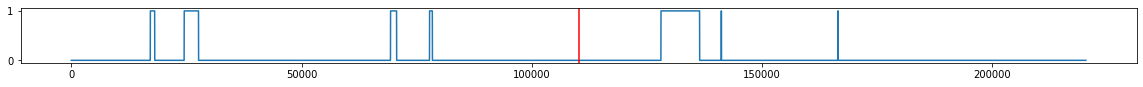

In [231]:
plt.figure(figsize=(20, 1))
plt.plot(y_target.values)
plt.axvline(train_end, color='red')
# plt.fill_betweenx([0, 1], 60000, 74000, color='red', alpha=0.2)
plt.show()

In [232]:
data_end

220320

In [233]:
ix_x = torch.arange(0, history_size).view(1, -1)
ix_x = ix_x + torch.arange(0, data_end - history_size - predict_size + 1).view(-1, 1)
ix_x

tensor([[     0,      1,      2,  ...,     17,     18,     19],
        [     1,      2,      3,  ...,     18,     19,     20],
        [     2,      3,      4,  ...,     19,     20,     21],
        ...,
        [220288, 220289, 220290,  ..., 220305, 220306, 220307],
        [220289, 220290, 220291,  ..., 220306, 220307, 220308],
        [220290, 220291, 220292,  ..., 220307, 220308, 220309]])

In [234]:
ix_y = torch.arange(predict_size).view(1, -1) + torch.arange(history_size, data_end - predict_size + 1).view(-1, 1)
ix_y

tensor([[    20,     21,     22,  ...,     27,     28,     29],
        [    21,     22,     23,  ...,     28,     29,     30],
        [    22,     23,     24,  ...,     29,     30,     31],
        ...,
        [220308, 220309, 220310,  ..., 220315, 220316, 220317],
        [220309, 220310, 220311,  ..., 220316, 220317, 220318],
        [220310, 220311, 220312,  ..., 220317, 220318, 220319]])

In [235]:
# ix_valid = (ix_y[:, 0] >= 60000) & (ix_y[:, 0] < 74000)
ix_train = (ix_y[:, 0] < train_end)
ix_valid = (ix_y[:, 0] >= train_end)   # & (ix_y[:, 0] < 150000)

In [236]:
ix_x.shape, ix_y.shape

(torch.Size([220291, 20]), torch.Size([220291, 10]))

In [237]:
x_tensor = torch.from_numpy(x_data.values).float()
y_tensor = torch.from_numpy(y_data.values).float()

In [238]:
(y_tensor[ix_y[ix_train]] == 0).sum() / (y_tensor[ix_y[ix_train]] == 1).sum()

tensor(17.4335)

In [239]:
x_mask = torch.stack([
    (y_tensor[ix_x].max(dim=1).values == 0) & (y_tensor[ix_y].max(dim=1).values == 0),
    (y_tensor[ix_x].max(dim=1).values == 0) & (y_tensor[ix_y].max(dim=1).values == 1),
    y_tensor[ix_x].max(dim=1).values,
], axis=1).bool()

In [240]:
x_mask.shape

torch.Size([220291, 3])

In [241]:
x_mask.sum(dim=0)

tensor([205604,     70,  14617])

In [242]:
ix_x.shape, y_target.shape, x_mask.shape, ix_train.shape, ix_valid.shape

(torch.Size([220291, 20]),
 (220320,),
 torch.Size([220291, 3]),
 torch.Size([220291]),
 torch.Size([220291]))

In [243]:
train_weights = torch.tensor([[0.5, 0, 0.5]]) / x_mask[ix_train].sum(dim=0, keepdim=True) * x_mask[ix_train]

In [244]:
train_weights.sum(dim=0)

tensor([0.5000, 0.0000, 0.5000])

In [245]:
train_weights = train_weights.sum(dim=1)

In [246]:
# train_weights = torch.ones(x_mask.size(0))[ix_train]

In [247]:
sampler = torch.utils.data.WeightedRandomSampler(
    weights=train_weights, 
    num_samples=10000,
    replacement=False, 
)
sampler = None

In [248]:
train_dl = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        x_tensor[ix_x[ix_train]], 
#         y_target[ix_train],
        x_mask[ix_train],
    ),
    shuffle=sampler is None,
    sampler=sampler,
    batch_size=64,
    num_workers=8,
)

valid_dl = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        x_tensor[ix_x[ix_valid]], 
#         y_target[ix_valid],
        x_mask[ix_valid],
    ),
    shuffle=False,
    batch_size=512,
    num_workers=4,
)

inference_dl = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        x_tensor[ix_x], 
#         y_target,
        x_mask,
    ),
    shuffle=False,
    batch_size=512,
    num_workers=4,
)

In [249]:
len(train_dl), len(valid_dl)

(1721, 216)

In [250]:
batch = next(iter(train_dl))
[t.shape for t in batch]

[torch.Size([64, 20, 51]), torch.Size([64, 3])]

## Model

In [251]:
# !rm -r lightning_logs/

In [252]:
history_size

20

In [253]:
import dltranz.lightning_modules.stream_encoder as se

In [254]:
from itertools import chain

In [255]:
class Noise(torch.nn.Module):
    def __init__(self, s):
        super().__init__()
        self.s = s
        
    def forward(self, x):
        if self.training:
            return x + torch.randn_like(x) * self.s
        return x

In [256]:
class MCounter(pl.metrics.Metric):
    def __init__(self, **params):
        super().__init__(**params)
        
        self.add_state('cnt', torch.Tensor([0]))
        
    def update(self, x):
        self.cnt += x.sum()
        
    def compute(self):
        return self.cnt

In [257]:
class SupModel(pl.LightningModule):
    def __init__(self, lr, weight_decay, step_size, gamma):
        super().__init__()
        self.save_hyperparameters()
        
        self.z_encoder = torch.nn.Sequential(
            se.TBatchNorm(x_data.shape[1]),
#             se.TDropout(0.2),
#             Noise(0.5),
#             torch.nn.Dropout(0.99),
#             se.TDropout(0.99),
#             torch.nn.Linear(x_data.shape[1], 12),
            torch.nn.Tanh(),
        )
        self.rnn = torch.nn.GRU(
            input_size=x_data.shape[1], hidden_size=16,
            batch_first=True,  
        )
        self.pre_head = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(16, 1),
#             torch.nn.Tanh(),
#             torch.nn.BatchNorm1d(6),
        )
        self.head = torch.nn.Sequential(
#             torch.nn.Linear(6, 1),
            torch.nn.Sigmoid(),
        )
#         self.head_normal = torch.nn.Sequential(
#             torch.nn.Linear(6, 1),
#             torch.nn.Sigmoid(),
#         )
#         self.head_early = torch.nn.Sequential(
#             torch.nn.Linear(6, 1),
#             torch.nn.Sigmoid(),
#         )
#         self.head_error = torch.nn.Sequential(
#             torch.nn.Linear(6, 1),
#             torch.nn.Sigmoid(),
#         )
        self.bce_loss = torch.nn.BCELoss()
        
        self.train_normal_incorrect = MCounter(compute_on_step=False)
        self.train_early_incorrect = MCounter(compute_on_step=False)
        self.train_error_incorrect = MCounter(compute_on_step=False)
        self.train_normal_total = MCounter(compute_on_step=False)
        self.train_early_total = MCounter(compute_on_step=False)
        self.train_error_total = MCounter(compute_on_step=False)
        self.valid_normal_incorrect = MCounter(compute_on_step=False)
        self.valid_early_incorrect = MCounter(compute_on_step=False)
        self.valid_error_incorrect = MCounter(compute_on_step=False)
        self.valid_normal_total = MCounter(compute_on_step=False)
        self.valid_early_total = MCounter(compute_on_step=False)
        self.valid_error_total = MCounter(compute_on_step=False)
        
        self.train_normal_detection = pl.metrics.Accuracy(compute_on_step=False)
        self.train_early_detection = pl.metrics.Accuracy(compute_on_step=False)
        self.train_error_detection = pl.metrics.Accuracy(compute_on_step=False)

        self.valid_normal_detection = pl.metrics.Accuracy(compute_on_step=False)
        self.valid_early_detection = pl.metrics.Accuracy(compute_on_step=False)
        self.valid_error_detection = pl.metrics.Accuracy(compute_on_step=False)
        
    def configure_optimizers(self):
#         o_params = [
#             {
#                 'params': chain(*[getattr(self, m).parameters() for m in ['z_encoder', 'rnn', 'head']]),
#                 'weight_decay': self.hparams.weight_decay,
#             },
#             {'params': chain(*[getattr(self, m).parameters() for m in []])},
#         ]
        o_params = self.parameters()
        opt = torch.optim.Adam(o_params, self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, self.hparams.step_size, self.hparams.gamma)
        return [opt], [scheduler]
        
    def forward(self, x):
        """x: B * T * H
        """
        z = self.z_encoder(x)
        out, _ = self.rnn(z, None)
#         c_m = out[:, [-20, -10, -5, -2, -1], :]
        c_m = out[:, [-1], :]
        c_m = c_m.reshape(c_m.size(0), -1)
        h = self.pre_head(c_m)
        return h
    
    def training_step(self, batch, batch_ix):
        x, mask = batch
        y = mask[:, 1] | mask[:, 2]
        h = self(x)
        y_hat = self.head(h).squeeze(1)
        loss_bce_y = self.bce_loss(y_hat, y.float())
        
#         loss_bce_normal = self.bce_loss(self.head_normal(h).squeeze(1), mask[:, 0].float())
#         loss_bce_early = self.bce_loss(self.head_early(h).squeeze(1), mask[:, 1].float())
#         loss_bce_error = self.bce_loss(self.head_error(h).squeeze(1), mask[:, 2].float())
        
        if mask[:, 0].sum() > 0:
            self.train_normal_detection(y_hat[mask[:, 0]], y.int()[mask[:, 0]])
            self.train_normal_incorrect(y_hat[mask[:, 0]] > 0.5)
            self.train_normal_total(1 - y.int()[mask[:, 0]])
        if mask[:, 1].sum() > 0:
            self.train_early_detection(y_hat[mask[:, 1]], y.int()[mask[:, 1]])
            self.train_early_incorrect(y_hat[mask[:, 1]] <= 0.5)
            self.train_early_total(y.int()[mask[:, 1]])
        if mask[:, 2].sum() > 0:
            self.train_error_detection(y_hat[mask[:, 2]], y.int()[mask[:, 2]])
            self.train_error_incorrect(y_hat[mask[:, 2]] <= 0.5)
            self.train_error_total(y.int()[mask[:, 2]])

        self.log('loss/bce_y', loss_bce_y, prog_bar=True)
#         self.log('loss/bce_normal', loss_bce_normal, prog_bar=True)
#         self.log('loss/bce_early', loss_bce_early, prog_bar=True)
#         self.log('loss/bce_error', loss_bce_error, prog_bar=True)
        
        self.log('data_train/0', mask[:, 0].float().mean())
        self.log('data_train/1', mask[:, 1].float().mean())
        self.log('data_train/2', mask[:, 2].float().mean())
        return loss_bce_y  # + loss_bce_normal + 10 * loss_bce_early + loss_bce_error
    
    def training_epoch_end(self, _):
        self.log('train/normal_detection', self.train_normal_detection, prog_bar=False)        
        self.log('train/early_detection', self.train_early_detection, prog_bar=False)        
        self.log('train/error_detection', self.train_error_detection, prog_bar=False)        

        self.log('train/normal_incorrect', self.train_normal_incorrect, prog_bar=False)        
        self.log('train/early_incorrect', self.train_early_incorrect, prog_bar=False)        
        self.log('train/error_incorrect', self.train_error_incorrect, prog_bar=False)        

        self.log('train/normal_total', self.train_normal_total, prog_bar=False)        
        self.log('train/early_total', self.train_early_total, prog_bar=False)        
        self.log('train/error_total', self.train_error_total, prog_bar=False)        

    def validation_step(self, batch, batch_ix):
        x, mask = batch
        y = mask[:, 1] | mask[:, 2]
        h = self(x)
        y_hat = self.head(h).squeeze(1)
        
        if mask[:, 0].sum() > 0:
            self.valid_normal_detection(y_hat[mask[:, 0]], y.int()[mask[:, 0]])
            self.valid_normal_incorrect(y_hat[mask[:, 0]] > 0.5)
            self.valid_normal_total(1 - y.int()[mask[:, 0]])
        if mask[:, 1].sum() > 0:
            self.valid_early_detection(y_hat[mask[:, 1]], y.int()[mask[:, 1]])
            self.valid_early_incorrect(y_hat[mask[:, 1]] <= 0.5)
            self.valid_early_total(y.int()[mask[:, 1]])
        if mask[:, 2].sum() > 0:
            self.valid_error_detection(y_hat[mask[:, 2]], y.int()[mask[:, 2]])
            self.valid_error_incorrect(y_hat[mask[:, 2]] <= 0.5)
            self.valid_error_total(y.int()[mask[:, 2]])
        
    def validation_epoch_end(self, _):
        self.log('valid/normal_detection', self.valid_normal_detection, prog_bar=True)
        self.log('valid/early_detection', self.valid_early_detection, prog_bar=True)
        self.log('valid/error_detection', self.valid_error_detection, prog_bar=True)

        self.log('valid/normal_incorrect', self.valid_normal_incorrect, prog_bar=False)        
        self.log('valid/early_incorrect', self.valid_early_incorrect, prog_bar=False)        
        self.log('valid/error_incorrect', self.valid_error_incorrect, prog_bar=False)        

        self.log('valid/normal_total', self.valid_normal_total, prog_bar=False)        
        self.log('valid/early_total', self.valid_early_total, prog_bar=False)        
        self.log('valid/error_total', self.valid_error_total, prog_bar=False)        


In [258]:
sup_model = SupModel(
    lr=0.001, weight_decay=0.1, step_size=10, gamma=0.8,
)

In [259]:
trainer = pl.Trainer(
    gpus=[0],
    max_epochs=10,
    log_every_n_steps=20,
    progress_bar_refresh_rate=50, weights_summary='full',
    logger=pl.loggers.TensorBoardLogger(
        save_dir='lightning_logs/',
        default_hp_metric=False,
    )
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [260]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    trainer.fit(sup_model, train_dataloader=train_dl, val_dataloaders=valid_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

   | Name                   | Type       | Params
-------------------------------------------------------
0  | z_encoder              | Sequential | 102   
1  | z_encoder.0            | TBatchNorm | 102   
2  | z_encoder.1            | Tanh       | 0     
3  | rnn                    | GRU        | 3.3 K 
4  | pre_head               | Sequential | 17    
5  | pre_head.0             | Dropout    | 0     
6  | pre_head.1             | Linear     | 17    
7  | head                   | Sequential | 0     
8  | head.0                 | Sigmoid    | 0     
9  | bce_loss               | BCELoss    | 0     
10 | train_normal_incorrect | MCounter   | 0     
11 | train_early_incorrect  | MCounter   | 0     
12 | train_error_incorrect  | MCounter   | 0     
13 | train_normal_total     | MCounter   | 0     
14 | train_early_total      | MCounter   | 0     
15 | train_error_total      | MCounter   | 0     
16 | valid_normal_incorrect | MCounter   | 0 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [261]:
trainer.logged_metrics

{'epoch': tensor(9.),
 'valid/normal_detection': tensor(0.9950),
 'valid/early_detection': tensor(0.3333),
 'valid/error_detection': tensor(0.5591),
 'valid/normal_incorrect': tensor(512.),
 'valid/early_incorrect': tensor(20.),
 'valid/error_incorrect': tensor(3777.),
 'valid/normal_total': tensor(101555.),
 'valid/early_total': tensor(30.),
 'valid/error_total': tensor(8566.),
 'loss/bce_y': tensor(0.0003, device='cuda:0'),
 'data_train/0': tensor(0.9667, device='cuda:0'),
 'data_train/1': tensor(0., device='cuda:0'),
 'data_train/2': tensor(0.0333, device='cuda:0'),
 'train/normal_detection': tensor(0.9995, device='cuda:0'),
 'train/early_detection': tensor(0.4750, device='cuda:0'),
 'train/error_detection': tensor(0.9912, device='cuda:0'),
 'train/normal_incorrect': tensor(53., device='cuda:0'),
 'train/early_incorrect': tensor(21., device='cuda:0'),
 'train/error_incorrect': tensor(53., device='cuda:0'),
 'train/normal_total': tensor(104049., device='cuda:0'),
 'train/early_total'

In [262]:
sup_model.eval()
X, Z, C, P, M = [], [], [], [], []
with torch.no_grad():
    for batch in tqdm(inference_dl):
        x, mask = batch
        z = sup_model.z_encoder(x)
        out, _ = sup_model.rnn(z, None)
        c_m1 = out[:, -1, :]
        proba = sup_model.head(sup_model.pre_head(c_m1)).squeeze(1)

        X.append(x[:, -1, :])
        Z.append(z[:, -1, :])
        C.append(c_m1)
        P.append(proba)
        M.append(mask)

  0%|          | 0/431 [00:00<?, ?it/s]

In [263]:
X = torch.cat(X, dim=0)
Z = torch.cat(Z, dim=0)
C = torch.cat(C, dim=0)
P = torch.cat(P, dim=0)
M = torch.cat(M, dim=0)

In [264]:
[t.shape for t in [X, Z, C, P, M]]

[torch.Size([220291, 51]),
 torch.Size([220291, 51]),
 torch.Size([220291, 16]),
 torch.Size([220291]),
 torch.Size([220291, 3])]

In [265]:
big_picture = torch.cat([
    M.float().view(-1, 3, 1).repeat(1, 1, 3).view(-1, 9),
    X,
    M.float().view(-1, 3, 1).repeat(1, 1, 3).view(-1, 9),
    Z,
    M.float().view(-1, 3, 1).repeat(1, 1, 3).view(-1, 9),
    C,
    M.float().view(-1, 3, 1).repeat(1, 1, 3).view(-1, 9),
    P.view(-1, 1).repeat(1, 10),
    M.float().view(-1, 3, 1).repeat(1, 1, 3).view(-1, 9),   
], axis=1)
big_picture = big_picture - big_picture.min(dim=0, keepdim=True).values
big_picture = big_picture / big_picture.max(dim=0, keepdim=True).values

In [266]:
P

tensor([1.6568e-06, 1.6605e-06, 1.6139e-06,  ..., 2.4714e-06, 2.4094e-06,
        2.4324e-06])

In [267]:
M[:20000].sum(dim=0)

tensor([19026,    10,   964])

In [268]:
P[:15000].mean()

tensor(1.8086e-06)

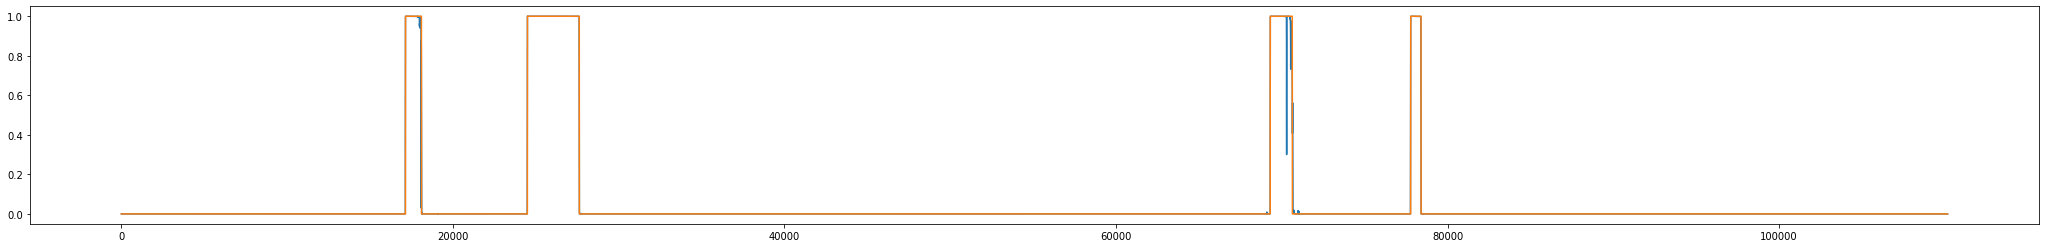

In [269]:
plt.figure(figsize=(36, 4))
plt.plot(P[:train_end].numpy())
plt.plot(M[:train_end, 2].numpy())
plt.show()

In [270]:
(
    (P[:train_end] > 0.5)[M[:train_end, 0]].float().sum(),
    (P[:train_end] <= 0.5)[M[:train_end, 1]].float().sum(),
    (P[:train_end] <= 0.5)[M[:train_end, 2]].float().sum(),
)

(tensor(10.), tensor(16.), tensor(23.))

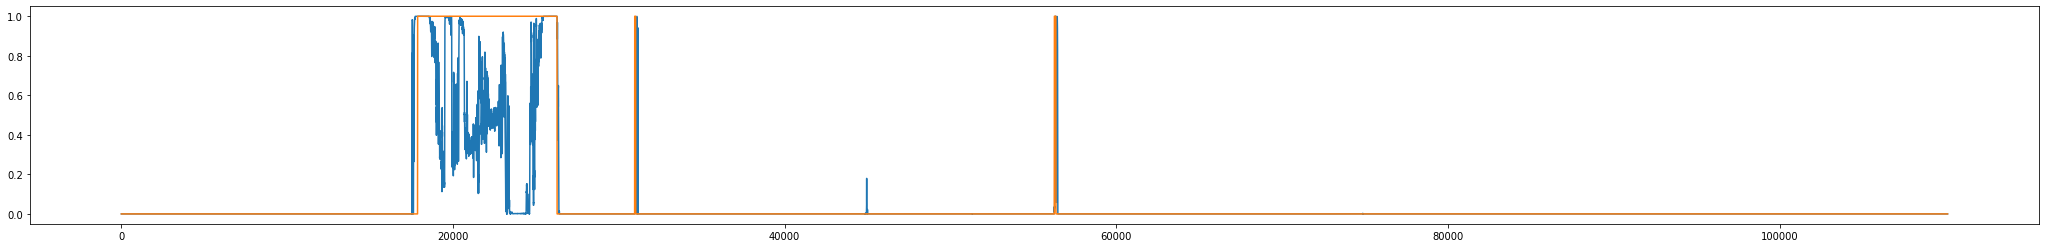

In [271]:
plt.figure(figsize=(36, 4))
plt.plot(P[train_end:].numpy())
plt.plot(M[train_end:, 2].numpy())
plt.show()

In [272]:
(
    (P[train_end:] > 0.5)[M[train_end:, 0]].float().sum(),
    (P[train_end:] <= 0.5)[M[train_end:, 1]].float().sum(),
    (P[train_end:] <= 0.5)[M[train_end:, 2]].float().sum(),
)

(tensor(512.), tensor(20.), tensor(3777.))

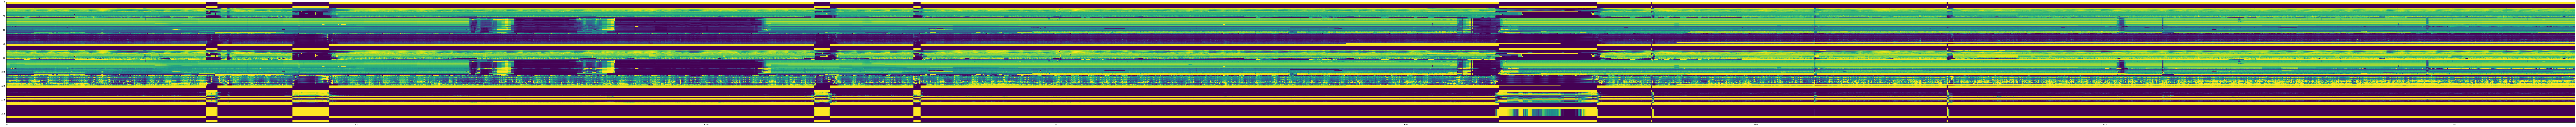

In [273]:
_, axs = plt.subplots(1, 1, figsize=(240, 3 * 5))

axs.imshow(big_picture.numpy().T[:, ::60])
plt.show()

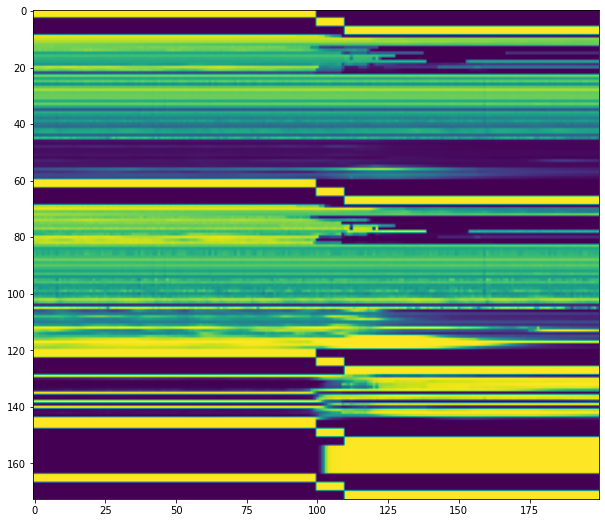

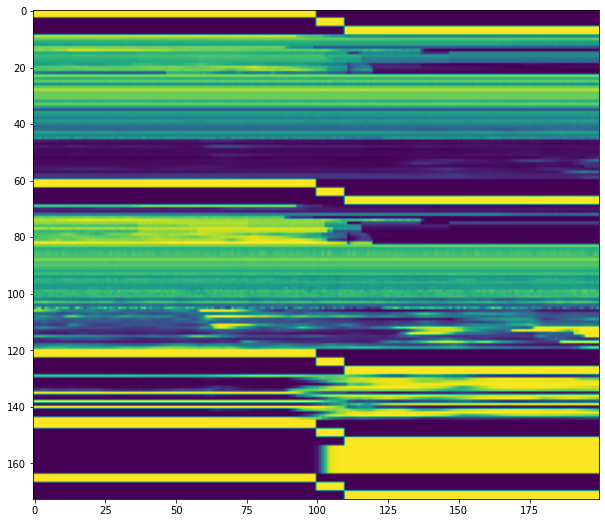

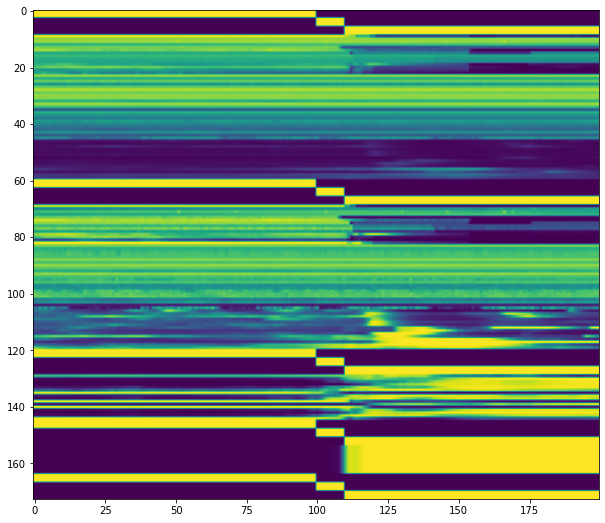

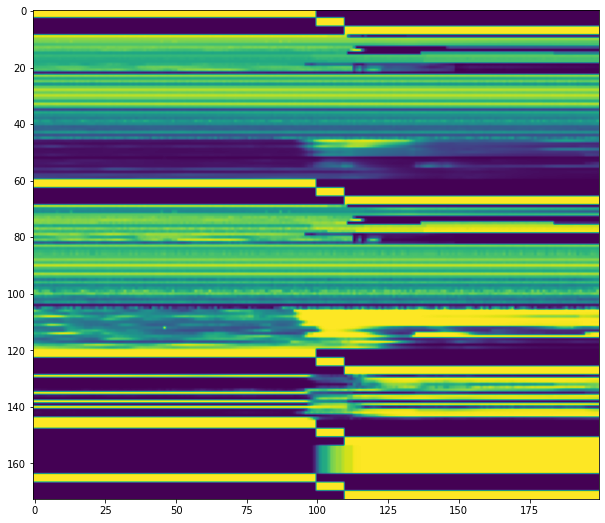

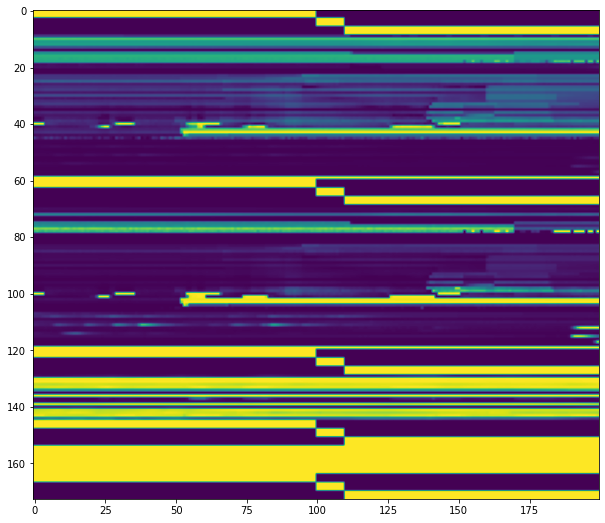

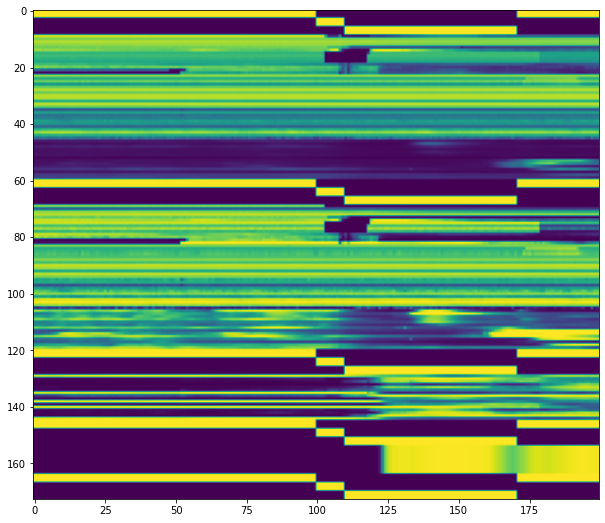

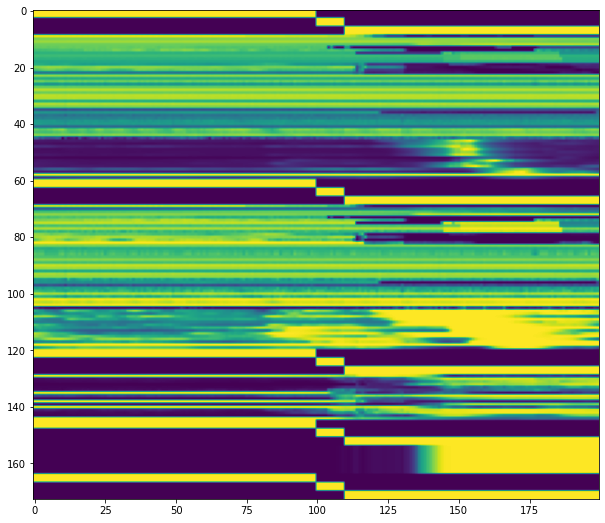

In [274]:
ix = M[:, 1].nonzero().flatten()
for pos in ix[ix.diff(prepend=-1 * torch.ones(1)) > 1]:
    _, axs = plt.subplots(1, 1, figsize=(36, 3 * 3))
    axs.imshow(big_picture.numpy().T[:, pos-100:pos+100])
    plt.show()   